# Bayesian moderation analysis

**Author:** [Benjamin T. Vincent](https://github.com/drbenvincent)

This notebook provides examples of how to conduct Bayesian [moderation analysis](https://en.wikipedia.org/wiki/Moderation_(statistics)). Note that this is not _mediation_ analysis, which is different. This is not intended as a one-stop solution to a wide variety of data analysis problems, rather, it is intended as an educational exposition to show you how moderation analysis works and how to conduct Bayesian parameter estimation in PyMC3.

In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

Entirely unrelated to the core concepts, we first define a useful helper function for plotting purposes. This function will create a Matplotlib `ScalarMappable` so we can use a consistent colormap across both data points and posterior predictive lines. We can use `scalarMap.cmap` to use as a colormap, and `scalarMap.to_rgba(moderator_value)` to grab a colour for a given moderator value.

In [2]:
def make_scalarMap(m):
    return ScalarMappable(norm=Normalize(vmin=np.min(m), vmax=np.max(m)), cmap="viridis")

# Example 1 - a continuous moderator

I've taken inspiration from [this example](https://www.spss-tutorials.com/spss-regression-with-moderation-interaction-effect/) by Ruben Geert van den Berg which examines whether age influences (moderates) the effect of training on muscle percentage. We might speculate that more training results in higher muscle mass, at least for younger people. But it might be the case that the relationship between training and muscle mass changes with age - perhaps training is less effective at increasing muscle mass in older age?

The schematic box and arrow notation for often used to represent moderation is shown by an arrow from the moderating variable to the line between a predictor and an outcome variable.

![](moderation_figure.png)

It can be useful to use consistent notation, so we will define:
- `x` as the main predictor variable. In this example it is training.
- `y` as the outcome variable. In this example it is muscle percentage.
- `m` as the mediator. In this example it is age.

## The moderation model

While the visual schematic is a useful shorthand to understand complex models when you already know what moderation is, it does not do a good job of describing what mediation is. So we will specify the moderation model - it defines an outcome variable $y$ as:

$$
y = \mathrm{Normal}(\beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m, \sigma^2)
$$

where $x$ and $m$ are your observed data, and the following are the model parameters:
- $\beta_0$ is the intercept
- $\beta_1$ is the rate at which $y$ increases per unit of $x$. If $\beta_1 \neq 0$ then we have a main effect of $x$. 
- $\beta_2$ is the coefficient for the moderation term $x \cdot m$.
- $\beta_3$ is the way in which y increases as $m$ increases. If $\beta_3 \neq 0$ then we have a main effect of $m$. 
- $\sigma$ is the standard deviation of the observation noise

## Import data
First, we will load up our example data and do some basic data visualisation.

In [3]:
def load_data():
    df = pd.read_csv("../data/muscle-percent-males-interaction.csv")
    # Extract zero-centered data
    x = df["thours"] - np.mean(df["thours"])
    m = df["age"] - np.mean(df["age"])
    y = df["mperc"] - np.mean(df["mperc"])
    return (x, y, m)

x, y, m = load_data()

# Make a scalar color map for this dataset. Just for plotting.
scalarMap = make_scalarMap(m)

In [4]:
# PLOT HISTOGRAMS HERE

## Define the PyMC3 model

In [5]:
def bayesian_moderation(y, x, m):
    """Conduct simple Bayesian moderation. 
    Returns the model and the trace."""

    with pm.Model() as model:
        # priors
        β0 = pm.Normal("β0", mu=0, sd=1)
        β1 = pm.Normal("β1", mu=0, sd=1)
        β2 = pm.Normal("β2", mu=0, sd=1)
        β3 = pm.Normal("β3", mu=0, sd=1)
        σ = pm.HalfCauchy("σ", 1)
        # likelihood
        y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sd=σ, observed=y)
        # sample
        trace = pm.sample(return_inferencedata=False)

    return model, trace

## Conduct inference

In [6]:
model, trace = bayesian_moderation(y, x, m)

n_samples = trace["β0"].shape[0]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β3, β2, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8789526346366511, but should be close to 0.8. Try to increase the number of tuning steps.


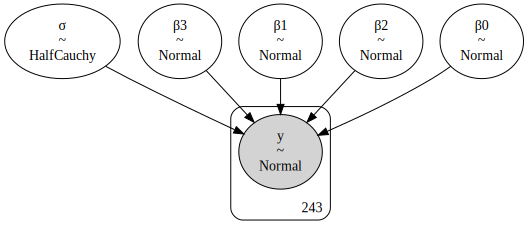

In [7]:
pm.model_to_graphviz(model)

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


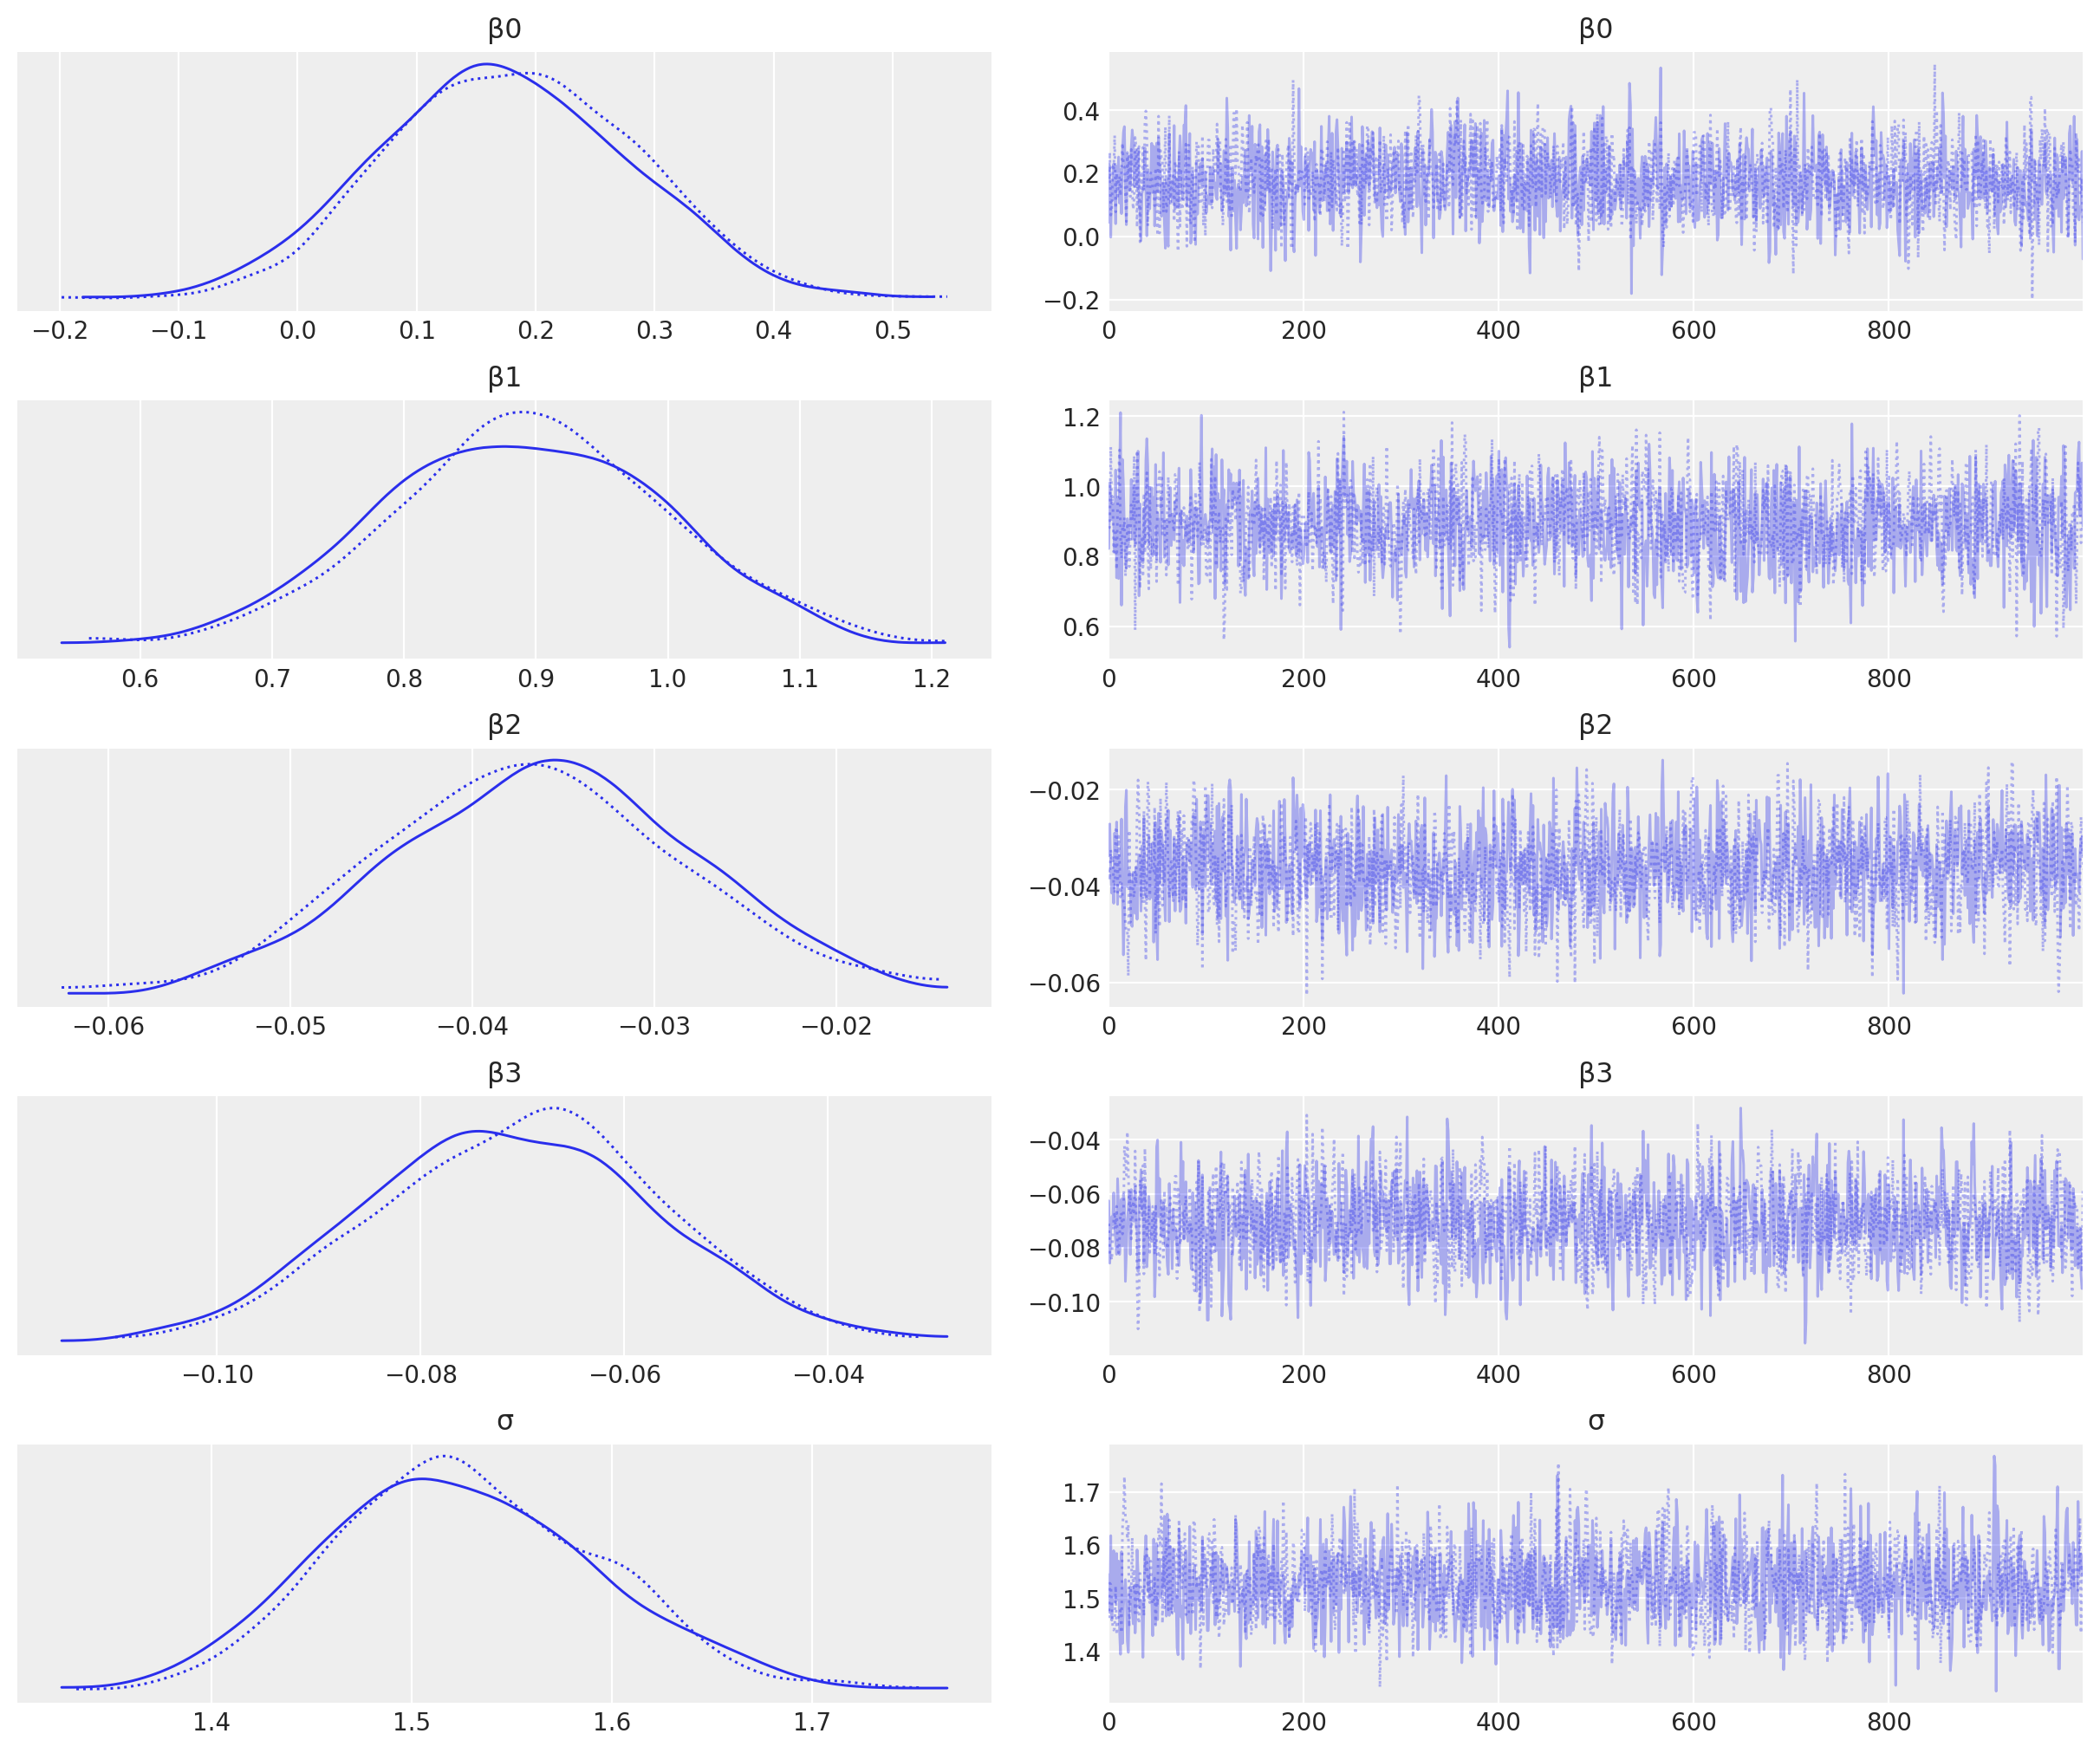

In [8]:
pm.plot_trace(trace);

## Visualise the results

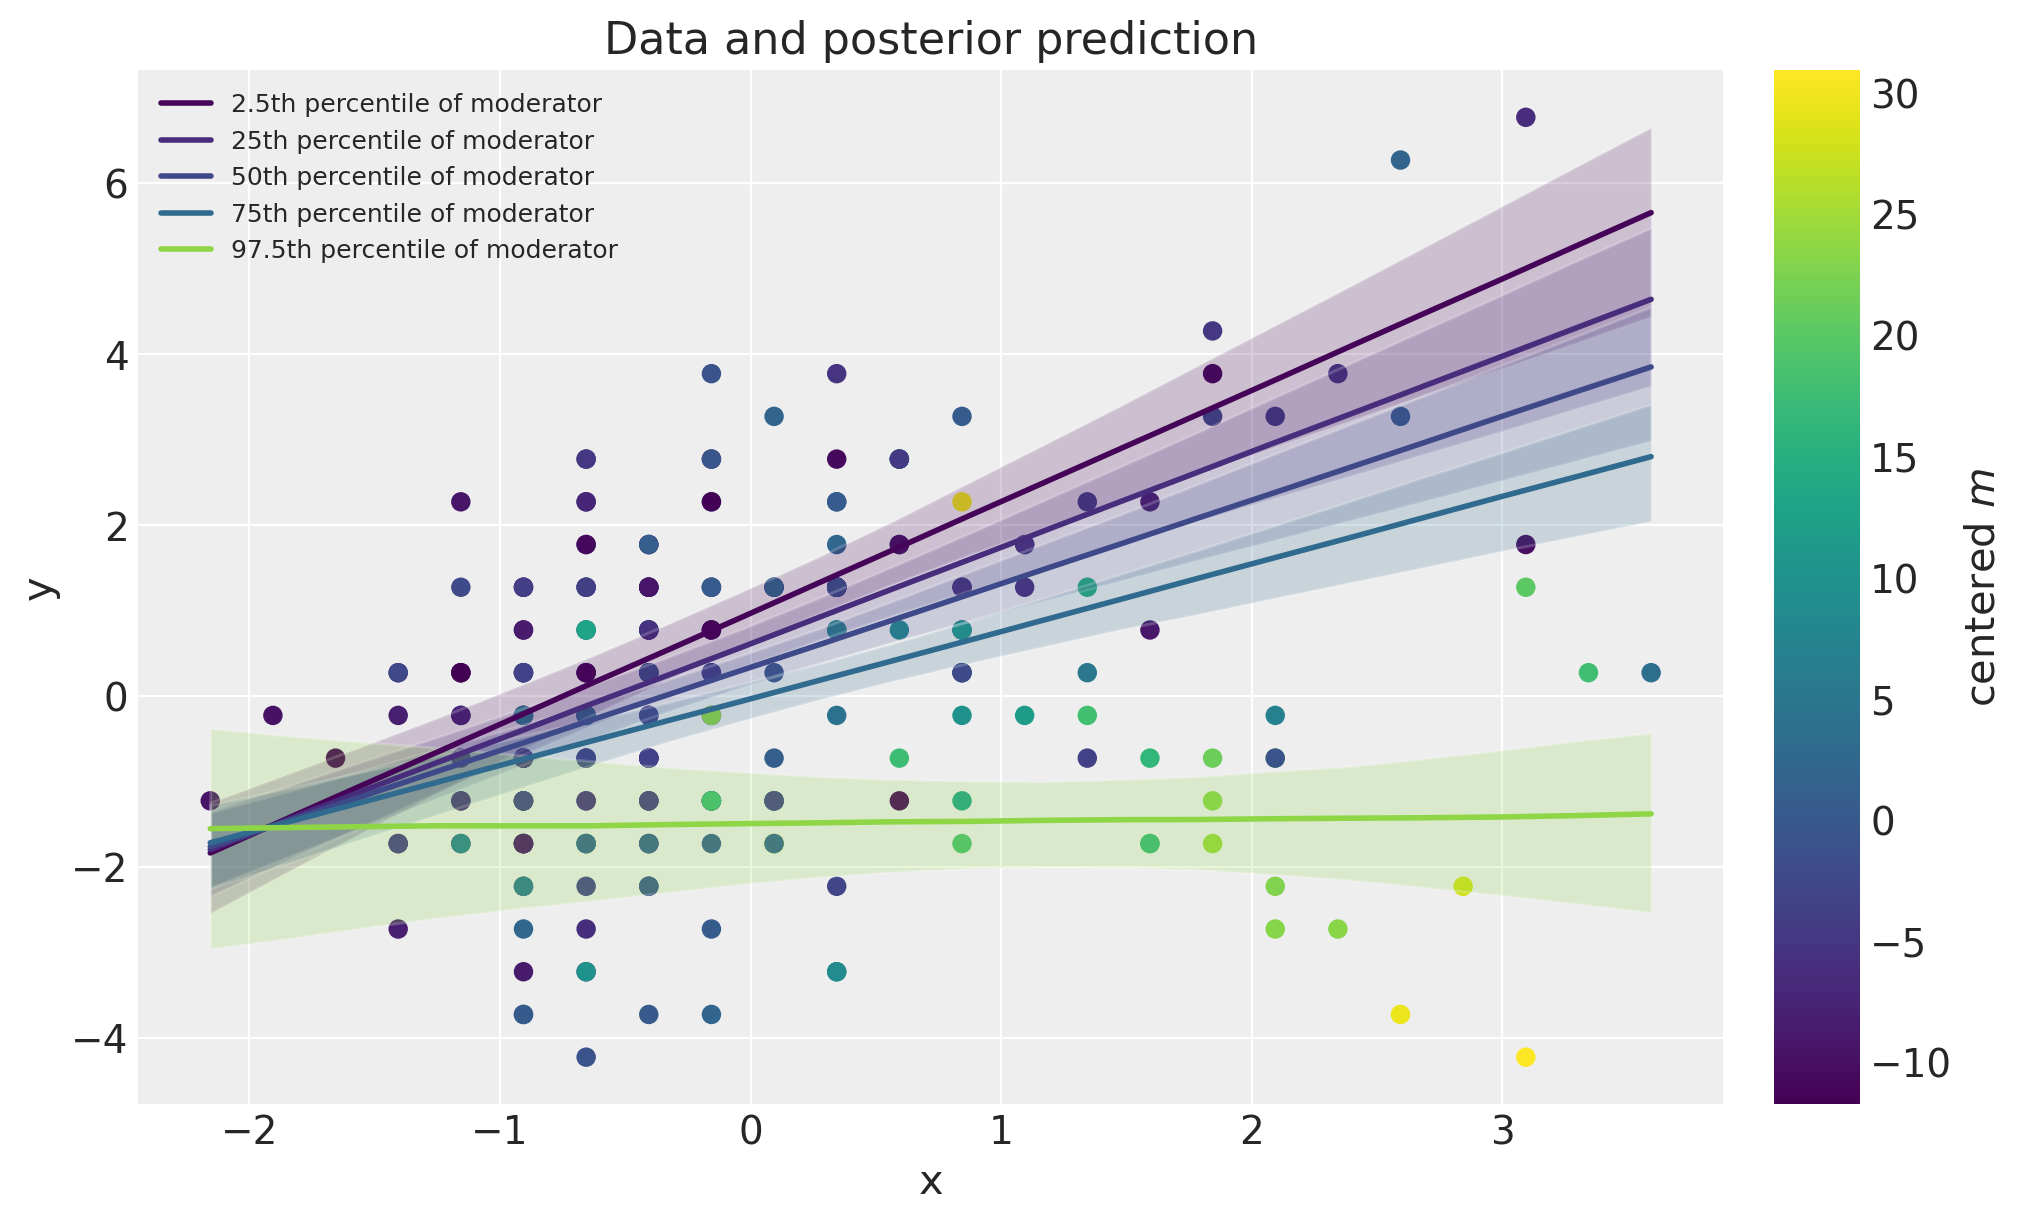

In [9]:
def plot_data(x, moderator, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    h = ax.scatter(x, y, c=moderator, cmap=scalarMap.cmap)
    ax.set(xlabel="centered $x$", ylabel="centered $y$")
    # colourbar for moderator
    cbar = fig.colorbar(h)
    cbar.ax.set_ylabel("centered $m$")
    return ax

def posterior_prediction_plot(
    trace, y, x, moderator, ax=None, percentile_list=[2.5, 25, 50, 75, 97.5]
):
    """Plot posterior predicted `y` for the defined moderator percentiles"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    # PLOT POSTERIOR PREDICTED `y` FOR DEFINED MODERATOR LEVELS
    xi = np.linspace(np.min(x), np.max(x), 20)
    m_levels = np.percentile(moderator, percentile_list)

    for p, m in zip(percentile_list, m_levels):
        β0 = np.expand_dims(trace["β0"], axis=1)
        β1 = np.expand_dims(trace["β1"], axis=1)
        β2 = np.expand_dims(trace["β2"], axis=1)
        β3 = np.expand_dims(trace["β3"], axis=1)
        _y = β0 + β1 * xi + β2 * xi * m + β3 * m
        region = np.percentile(_y, [2.5, 50, 95], axis=0)

        ax.fill_between(
            xi,
            region[0, :],
            region[2, :],
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region[1, :],
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(figsize=(10, 6))
plot_data(x, m, y, ax=ax)
posterior_prediction_plot(trace, y, x, m, ax=ax)
ax.set_title("Data and posterior prediction");

Closer look at the moderation effect

In [10]:
def plot_moderation_effect(x, m, y,
    ax=None,
    true_β1=None,
    true_β2=None,
    percentile_list=[0, 2.5, 25, 50, 75, 97.5, 100],
    samples_to_plot=100,
):

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    m = np.linspace(np.min(m), np.max(m), 2)

    # sample from posterior
    if samples_to_plot < n_samples:
        ind = np.random.choice(range(n_samples), samples_to_plot)

    β1 = np.expand_dims(trace["β1"], axis=1)[ind, :]
    β2 = np.expand_dims(trace["β2"], axis=1)[ind, :]
    rate = β1 + β2 * m

    # spaghetti plot
    for n in range(samples_to_plot):
        ax.plot(m, rate[n, :], "k", alpha=0.1)

    # plot true model, if known
    if (true_β1 is not None) and (true_β2 is not None):
        true = true_β1 + true_β2 * m
        ax.plot(m, true, "r", lw=3, label="true")

    # plot points at each percentile of m
    m_levels = np.percentile(m, percentile_list)
    for m in m_levels:
        ax.plot(
            m, np.mean(β1) + np.mean(β2) * m, "o", c=scalarMap.to_rgba(m), markersize=10
        )

    ax.legend()

    ax.set(
        title="moderation effect",
        xlabel="$moderator$",
        ylabel=r"$\beta_1 + \beta_2 \cdot moderator$",
    )

No handles with labels found to put in legend.
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


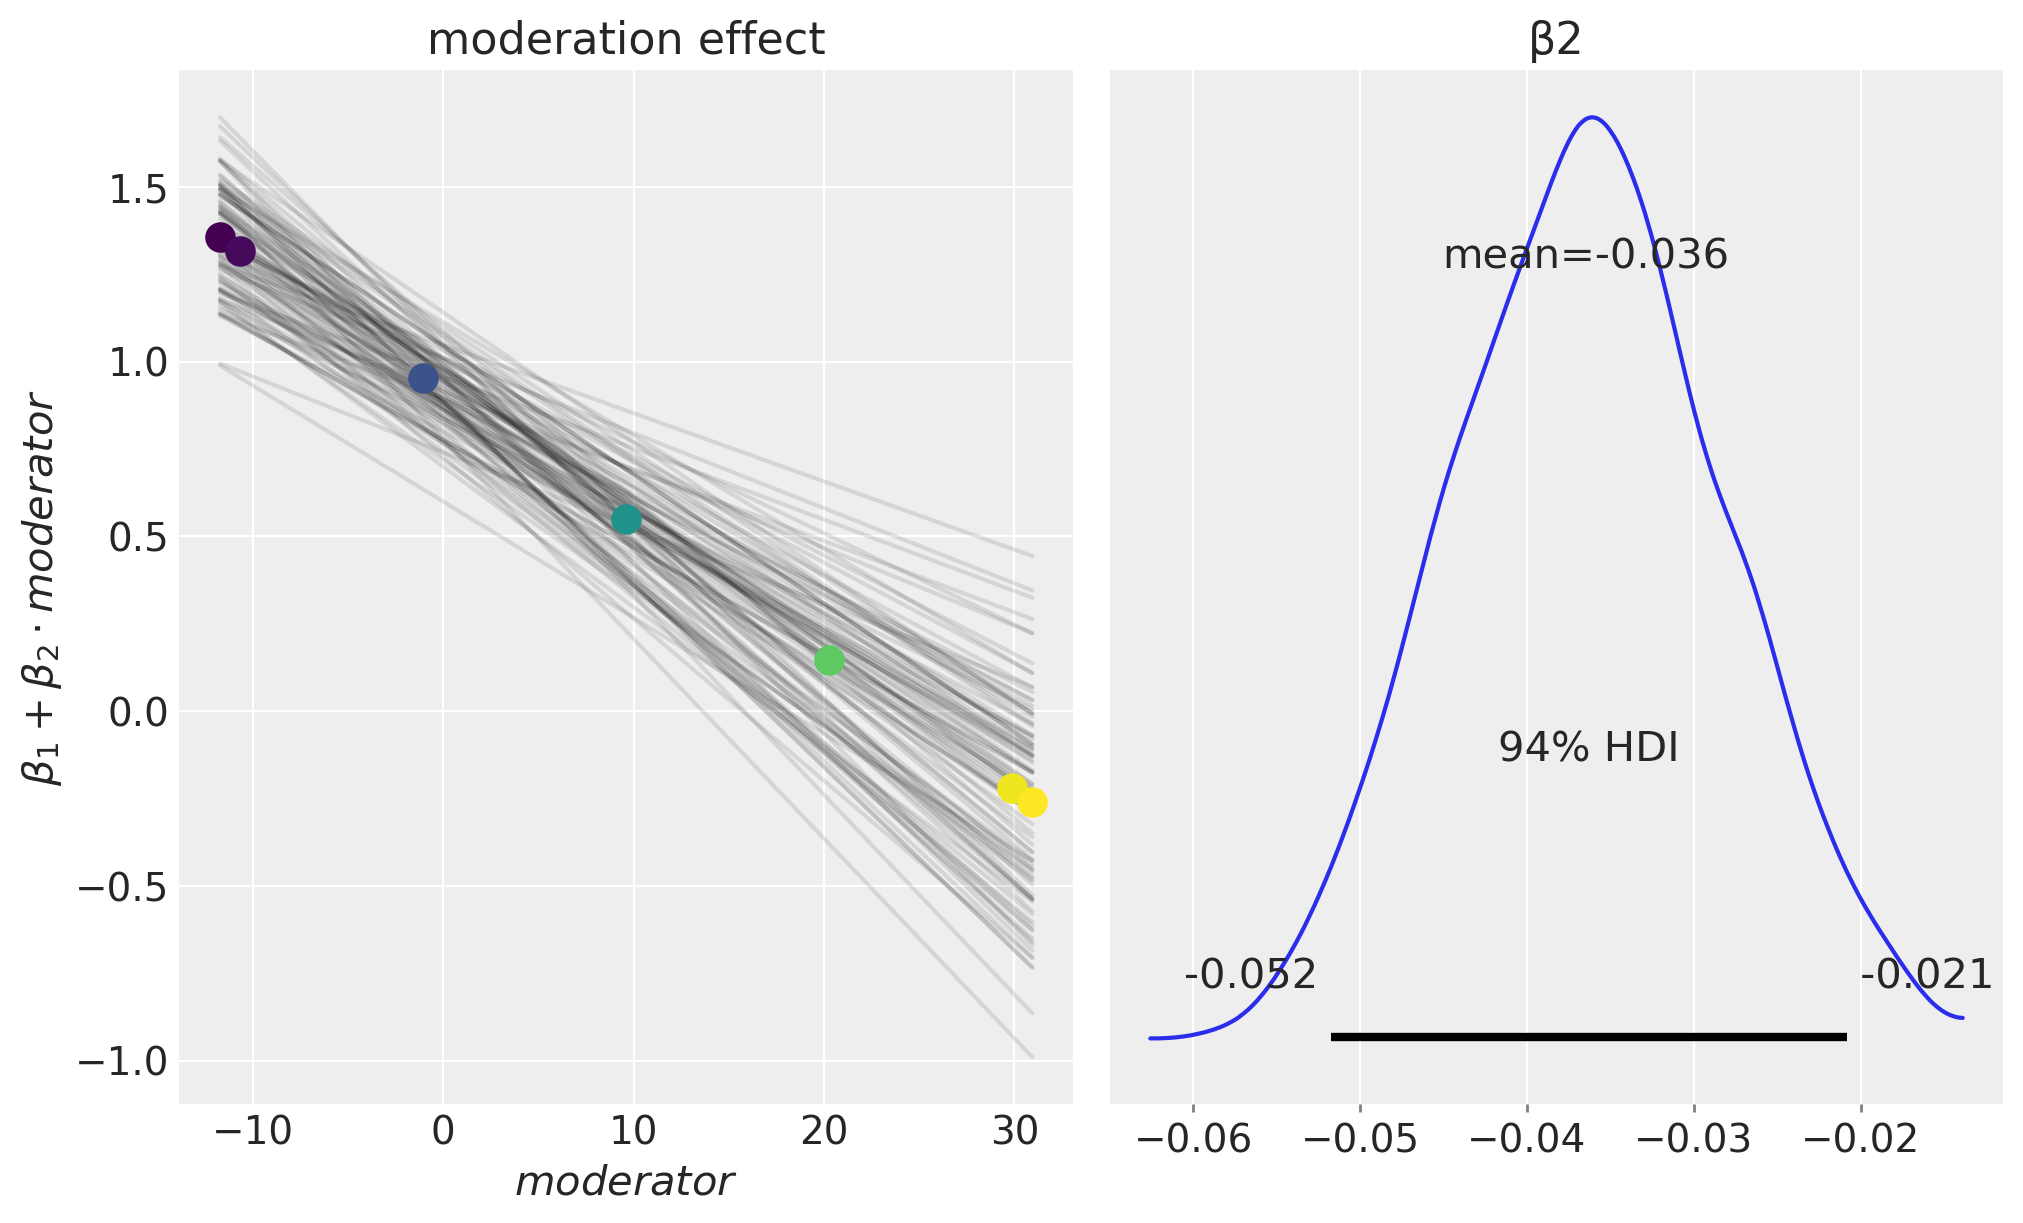

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

plot_moderation_effect(x, m, y, ax[0])
az.plot_posterior(trace, var_names="β2", ax=ax[1]);

# Example 2 - a categorical moderator



**NOTE:** Priors in the PyMC3 model need to be updated to fit your particular situation. This is especially the case for the moderation term $\beta_2$.




# Example 3 - simulated data

## Simulate and plot fake data

In [12]:
def make_data(β0=0.5, β1=1, β2=0.7, β3=1, σ=1, N=300):
    # make a dict, useful for future use
    true_params = {"β0": β0, "β1": β1, "β2": β2, "β3": β3, "σ": σ}

    # generate fake data
    x = np.random.randn(N)
    moderator = np.random.randn(N)
    μ = β0 + β1 * x + β2 * x * moderator + β3 * moderator
    ϵ = np.random.randn(N) * σ
    y = μ + ϵ
    return x, moderator, y, true_params


x, m, y, true_params = make_data()

# Make a scalar color map for this dataset. Just for plotting.
scalarMap = make_scalarMap(m)

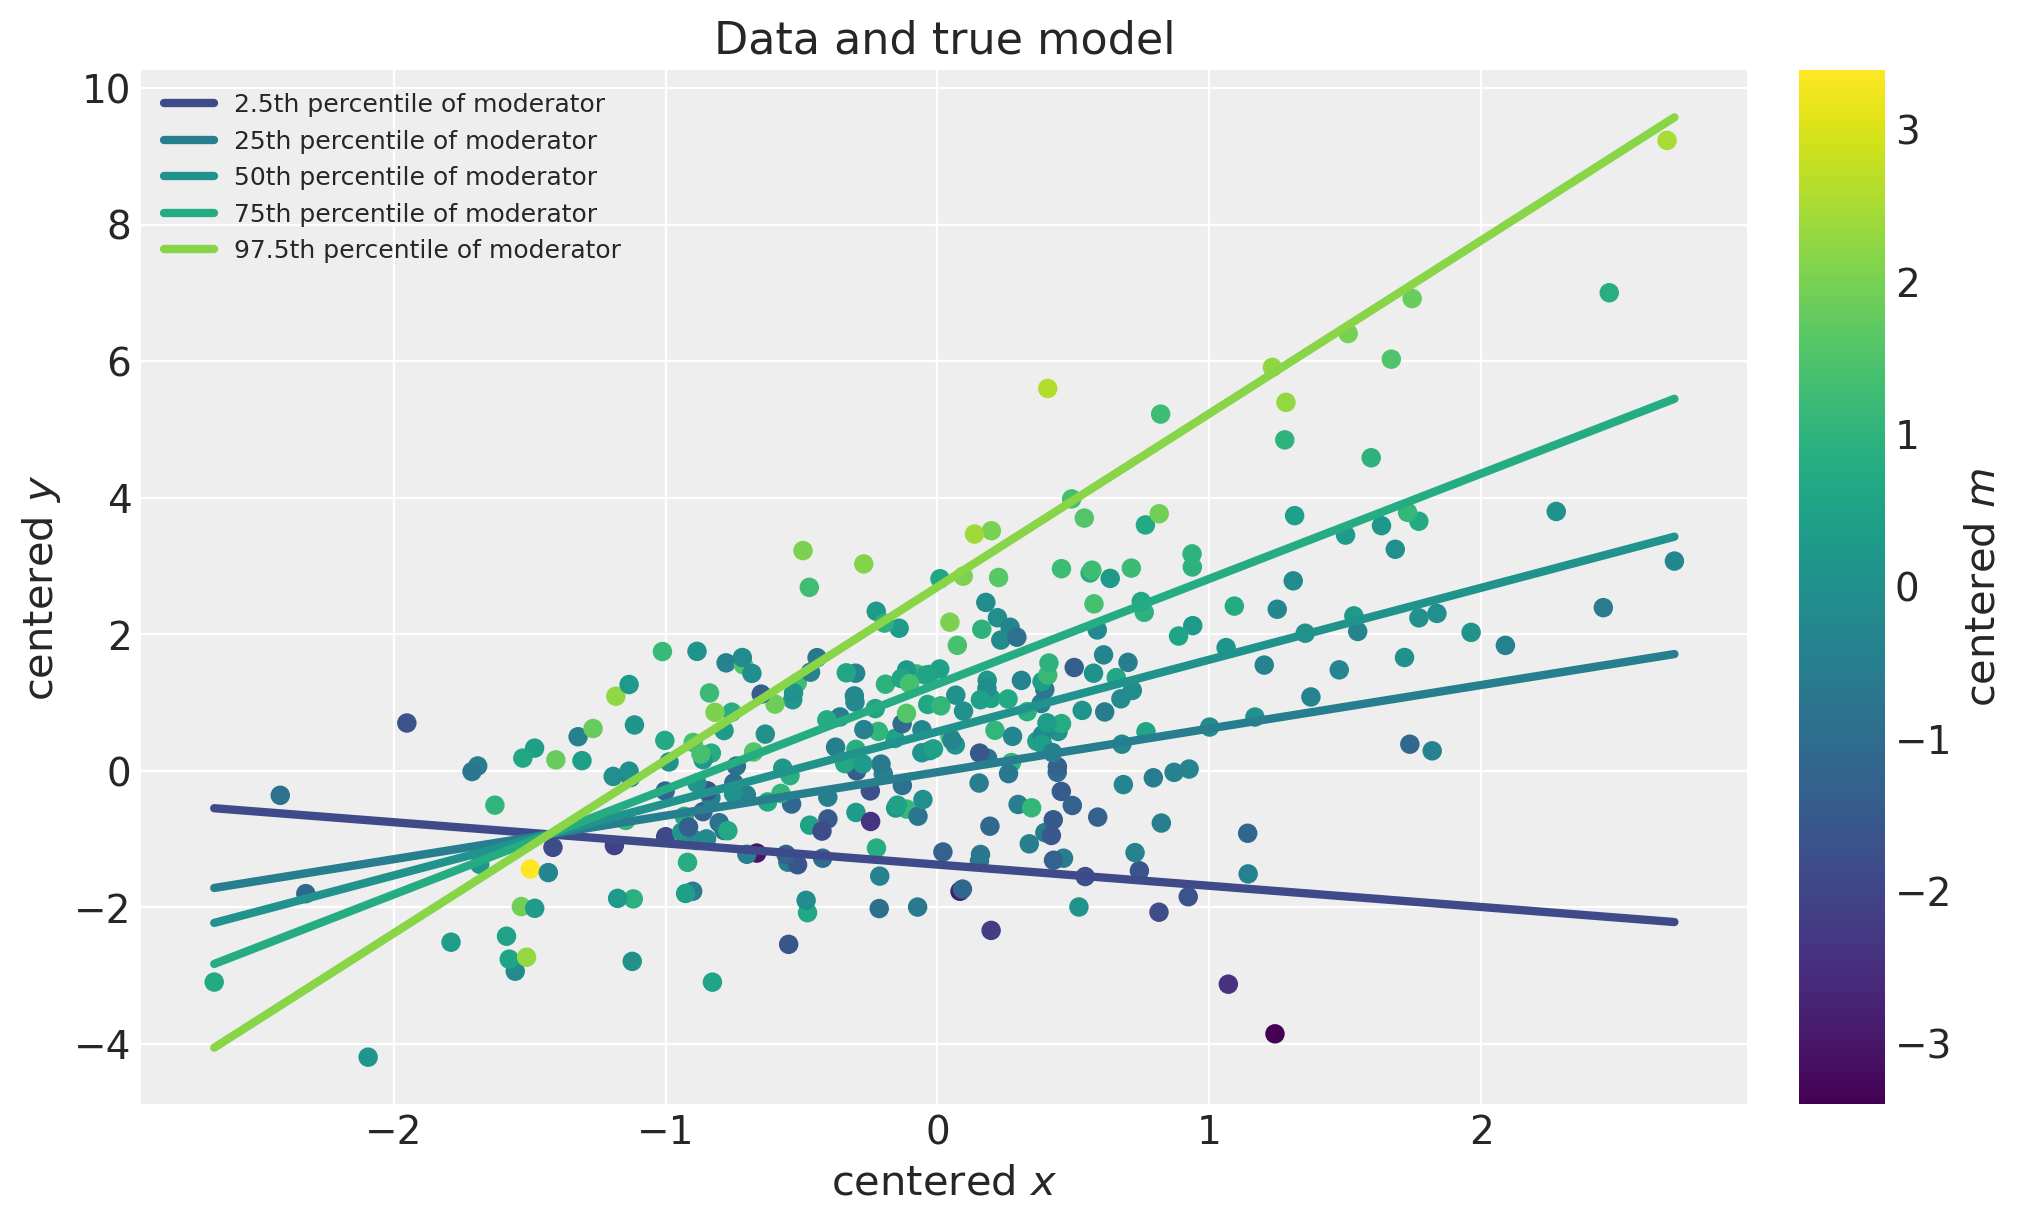

In [13]:
def plot_true(ax, params, x, m):
    _x = np.linspace(np.min(x), np.max(x), 10)
    moderator_percentiles = [2.5, 25, 50, 75, 97.5]
    m_levels = np.percentile(m, moderator_percentiles)
    for p, m in zip(moderator_percentiles, m_levels):
        μ = params["β0"] + params["β1"] * _x + params["β2"] * _x * m + params["β3"] * m
        ax.plot(
            _x, μ, lw=3, label=f"{p}th percentile of moderator", c=scalarMap.to_rgba(m)
        )
    ax.legend(fontsize=9)
    
    
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_data(x, m, y, ax=ax)
plot_true(ax, true_params, x, m)
ax.set_title("Data and true model");

## Build PyMC3 model

In [14]:
# def bayesian_moderation(y, x, m):
#     """Conduct simple Bayesian moderation. 
#     Returns the model and the trace."""

#     print("WARNING: Priors must be updated to suit your speicific data context")

#     with pm.Model() as model:
#         # priors
#         β0 = pm.Normal("β0", mu=0, sd=1)
#         β1 = pm.Normal("β1", mu=0, sd=1)
#         β2 = pm.Normal("β2", mu=0, sd=1)
#         β3 = pm.Normal("β3", mu=0, sd=1)
#         σ = pm.HalfCauchy("σ", 1)
#         # likelihood
#         y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sd=σ, observed=y)
#         # sample
#         trace = pm.sample(return_inferencedata=False)

#     return model, trace

In [15]:
model, trace = bayesian_moderation(y, x, m)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β3, β2, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


Assess the fits by inspecting the chains and posterior distributions.

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


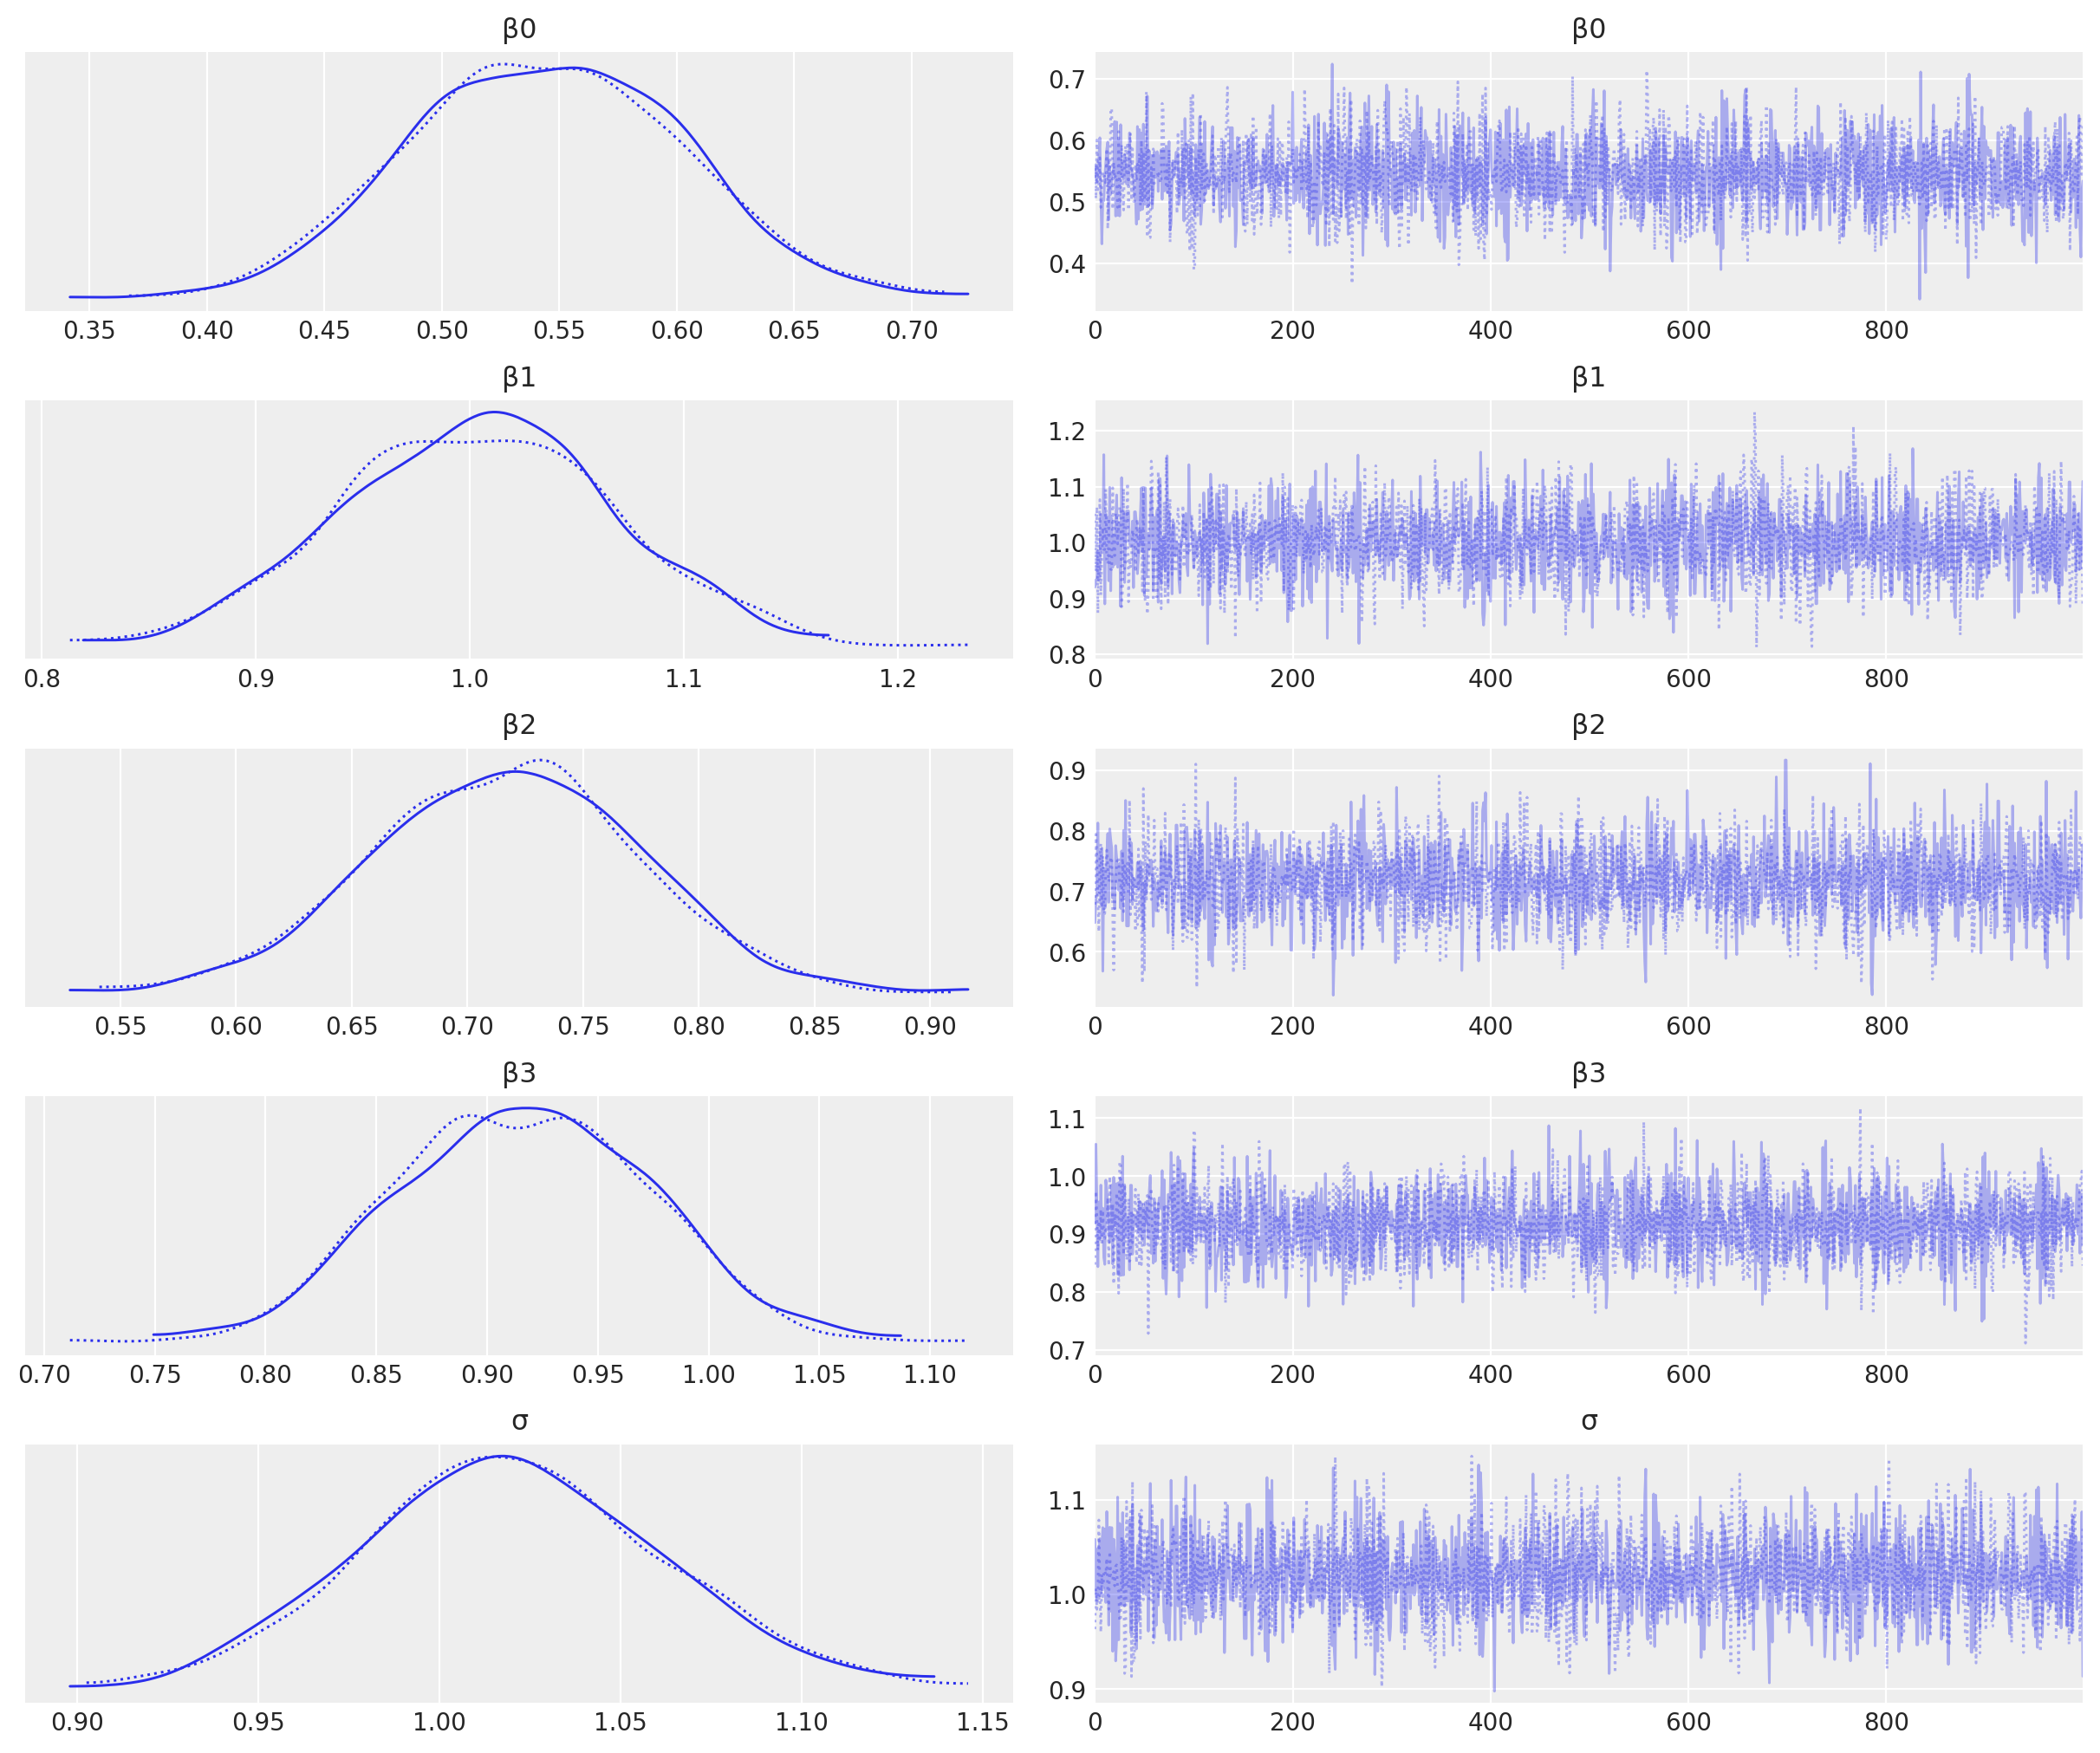

In [16]:
pm.plot_trace(trace);

Examine the posterior distributions, in comparison to the known true parameter values.

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 wit

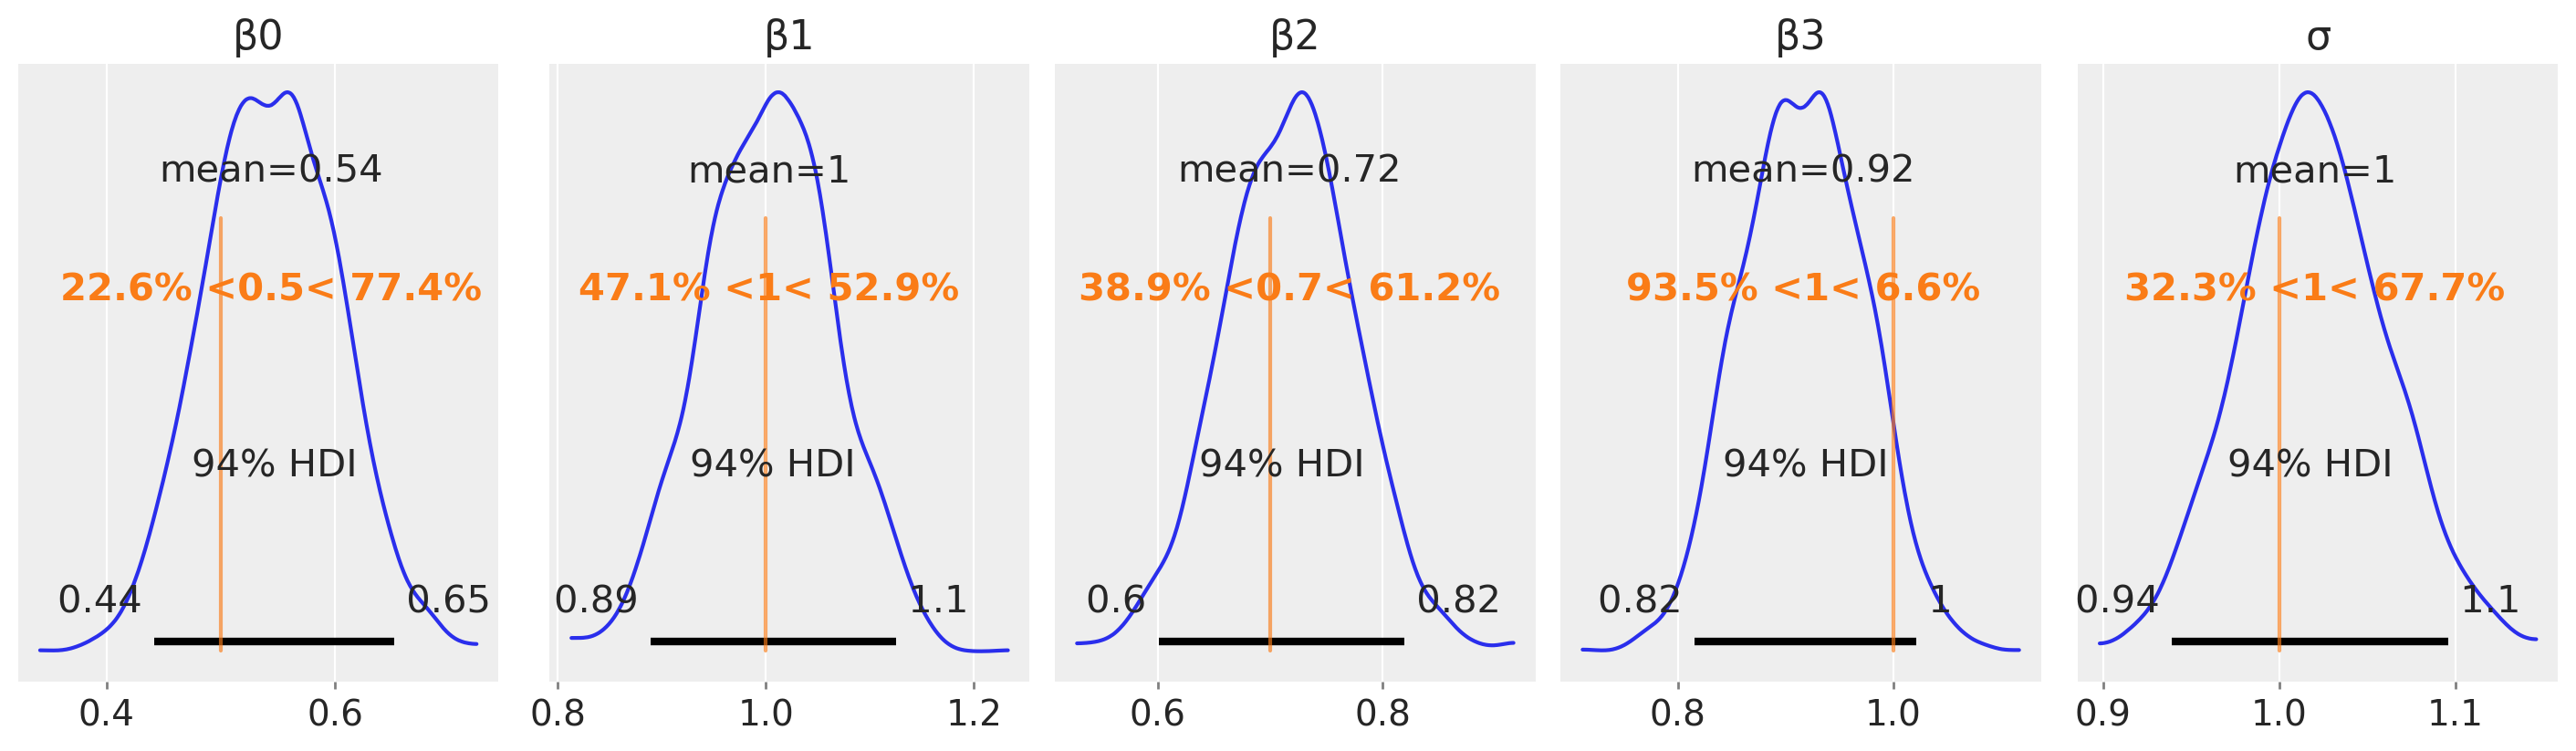

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(14, 4))
for i, (key, val) in enumerate(true_params.items()):
    az.plot_posterior(trace, var_names=key, ax=ax[i], ref_val=val)

## Posterior prediction

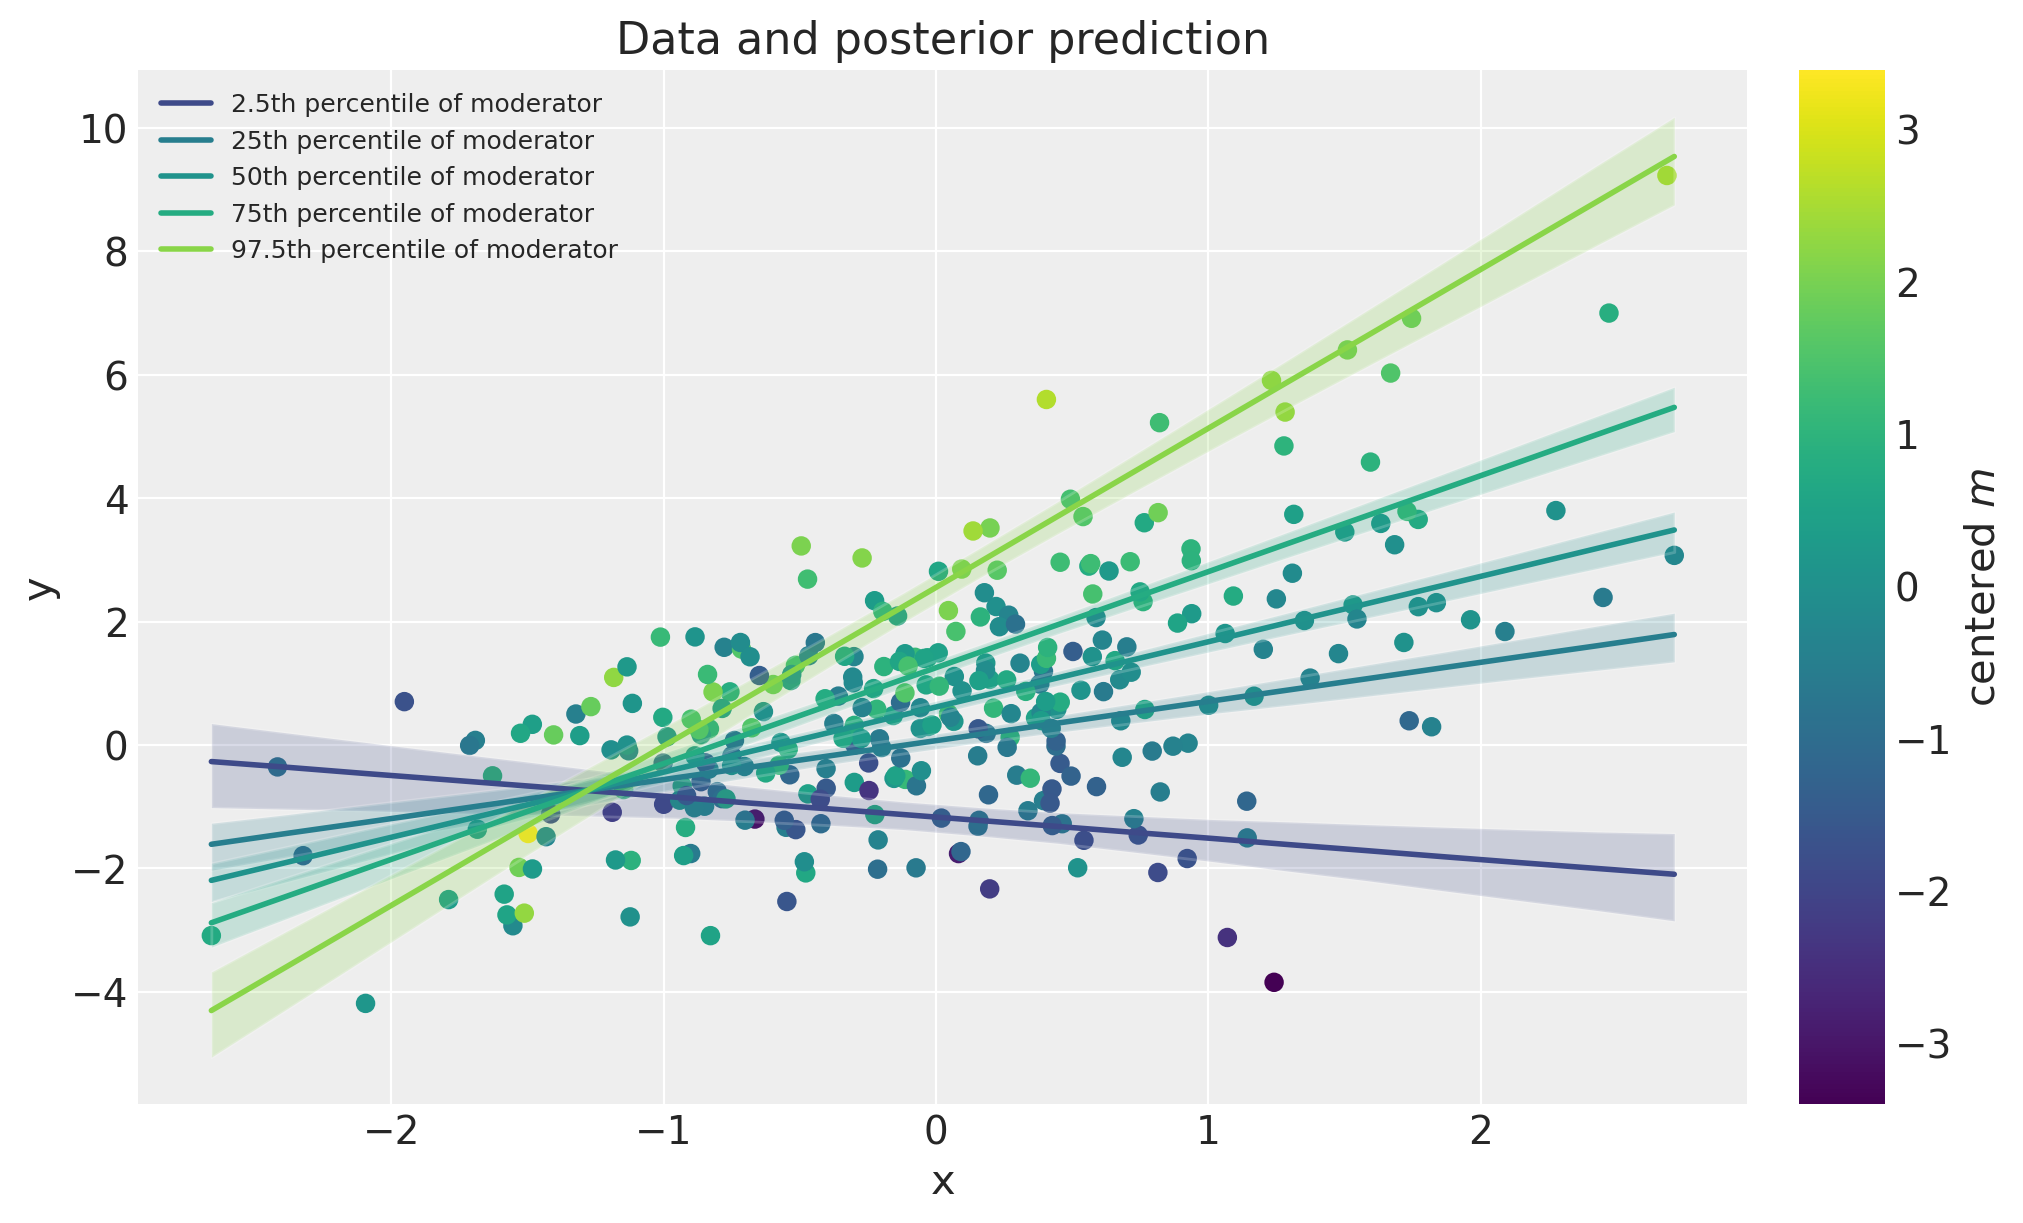

In [18]:
def posterior_prediction_plot(
    trace, y, x, moderator, ax=None, percentile_list=[2.5, 25, 50, 75, 97.5]
):
    """Plot posterior predicted `y` for the defined moderator percentiles"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # PLOT POSTERIOR PREDICTED `y` FOR DEFINED MODERATOR LEVELS
    xi = np.linspace(np.min(x), np.max(x), 20)
    m_levels = np.percentile(moderator, percentile_list)

    for p, m in zip(percentile_list, m_levels):
        β0 = np.expand_dims(trace["β0"], axis=1)
        β1 = np.expand_dims(trace["β1"], axis=1)
        β2 = np.expand_dims(trace["β2"], axis=1)
        β3 = np.expand_dims(trace["β3"], axis=1)
        _y = β0 + β1 * xi + β2 * xi * m + β3 * m
        region = np.percentile(_y, [2.5, 50, 95], axis=0)

        ax.fill_between(
            xi,
            region[0, :],
            region[2, :],
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region[1, :],
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(figsize=(10, 6))
plot_data(x, m, y, ax=ax)
posterior_prediction_plot(trace, y, x, m, ax=ax)
ax.set_title("Data and posterior prediction");

Now examine the moderation effect in more detail.

The moderation model 
$$
y = \mathrm{Normal}(\beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot moderator + \beta_3 \cdot moderator, \sigma^2)
$$

can be re-written as

$$
y = \mathrm{Normal}(\beta_0 + x (\beta_1 + \beta_2 \cdot moderator) + \beta_3 \cdot moderator, \sigma^2)
$$

where $\beta_1 + \beta_2 \cdot moderator$ describes how the moderator influences the linear relationship between $x$ and $y$.

In [19]:
# n_samples = trace["β0"].shape[0]

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


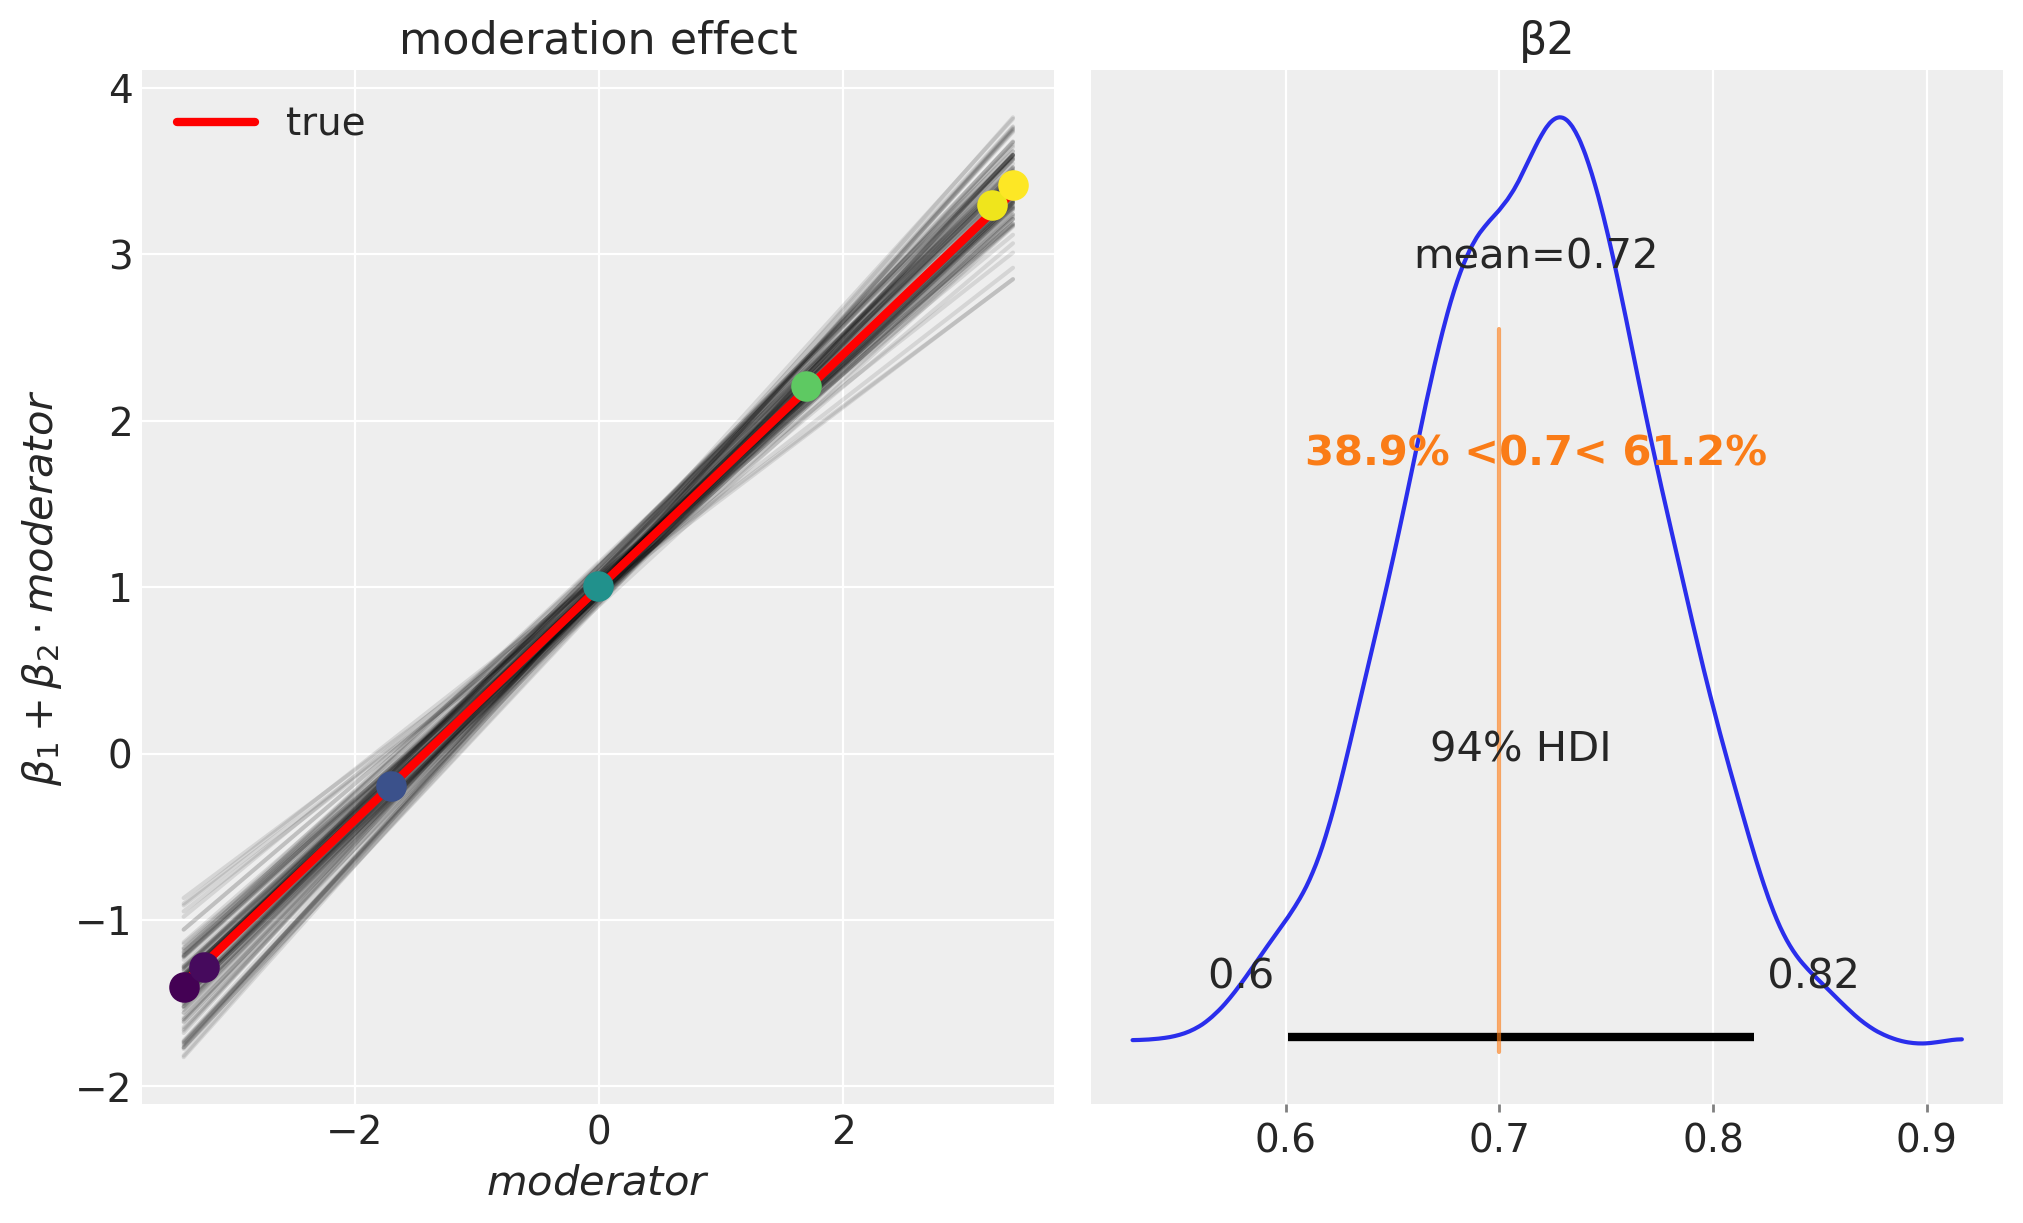

In [20]:
# def plot_moderation_effect(x, m, y,
#     ax=None,
#     true_β1=None,
#     true_β2=None,
#     percentile_list=[0, 2.5, 25, 50, 75, 97.5, 100],
#     samples_to_plot=100,
# ):

#     if ax is None:
#         fig, ax = plt.subplots(1, 1)

#     m = np.linspace(np.min(m), np.max(m), 2)

#     # sample from posterior
#     if samples_to_plot < n_samples:
#         ind = np.random.choice(range(n_samples), samples_to_plot)

#     β1 = np.expand_dims(trace["β1"], axis=1)[ind, :]
#     β2 = np.expand_dims(trace["β2"], axis=1)[ind, :]
#     rate = β1 + β2 * m

#     # spaghetti plot
#     for n in range(samples_to_plot):
#         ax.plot(m, rate[n, :], "k", alpha=0.1)

#     # plot true model, if known
#     if (true_β1 is not None) and (true_β2 is not None):
#         true = true_β1 + true_β2 * m
#         ax.plot(m, true, "r", lw=3, label="true")

#     # plot points at each percentile of m
#     m_levels = np.percentile(m, percentile_list)
#     for m in m_levels:
#         ax.plot(
#             m, np.mean(β1) + np.mean(β2) * m, "o", c=scalarMap.to_rgba(m), markersize=10
#         )

#     ax.legend()

#     ax.set(
#         title="moderation effect",
#         xlabel="$moderator$",
#         ylabel=r"$\beta_1 + \beta_2 \cdot moderator$",
#     )


fig, ax = plt.subplots(1, 2, figsize=(10, 6))

plot_moderation_effect(x, m, y, ax[0], true_β1=true_params["β1"], true_β2=true_params["β2"])
az.plot_posterior(trace, var_names="β2", ax=ax[1], ref_val=true_params["β2"]);

# References

- [SPSS Moderation Regression Tutorial](https://www.spss-tutorials.com/spss-regression-with-moderation-interaction-effect/) by Ruben Geert van den Berg

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Mar 23 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.21.0

numpy     : 1.19.2
pymc3     : 3.11.2
arviz     : 0.11.2
matplotlib: 3.3.4
pandas    : 1.2.3

Watermark: 2.2.0

